In [20]:
cells = {'Basket':{'segID':[864691135269913253],
                   'distances':[]},
         'Martinotti':{'segID':[864691135654096066,
                                864691136483096108,
                                864691136866902638,
                                864691135390890482,
                                864691136296781083],
                       'distances':[]}}

In [1]:
from caveclient import CAVEclient
import nglui
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v117')

In [21]:
def get_synaptic_distances(segID):
    """
    """
    # get soma position
    cell = client.materialize.query_table('nucleus_detection_v0',
                                          filter_equal_dict={'pt_root_id':segID})
    # get synapses
    synapses = client.materialize.synapse_query(post_ids=segID)
    distances, exceptions = [], 0
    for n in range(len(synapses)):
        try:
            distances.append(np.sqrt(\
                                     (synapses.ctr_pt_position[n][0]-cell.pt_position[0][0])**2+\
                                     (synapses.ctr_pt_position[n][1]-cell.pt_position[0][1])**2+\
                                     (synapses.ctr_pt_position[n][2]-cell.pt_position[0][2])**2))
        except BaseException as be:
            exceptions +=1

    print('%i synapses not added ' % exceptions)
    return distances

for key in ['Basket', 'Martinotti']:
    cells[key]['distances'] = []
    for segID in cells[key]['segID']:
        cells[key]['distances'].append(get_synaptic_distances(segID))

32 synapses not added 
19 synapses not added 
19 synapses not added 
7 synapses not added 
32 synapses not added 
15 synapses not added 


Text(0.5, 0, 'distance from soma (voxel-units)')

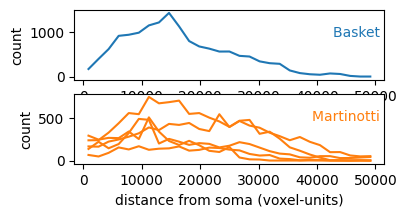

In [76]:
xmax = 100000
xmax = 50000 # zoomed

fig, AX = plt.subplots(2, 1, figsize=(4,2))
for ax, key, color in zip(AX, ['Basket', 'Martinotti'], [plt.cm.tab10(0), plt.cm.tab10(1)]):
    for distances in cells[key]['distances']:
        hist, be = np.histogram(distances, bins=np.linspace(0,xmax,30))
        ax.plot(0.5*(be[1:]+be[:-1]), hist, color=color)
    ax.set_ylabel('count')
    ax.annotate('\n'+key+' ', (1,1), ha='right', va='top', color=color, xycoords='axes fraction')

plt.xlabel('distance from soma (voxel-units)')

In [77]:
def plot_synapses(seg_id, 
                  ax=None, subsampling=10,
                  i=0, j=1, # projection
                  color='k'):
    if ax is None:
        fig, ax = plt.subplots(1)
    
    cell = client.materialize.query_table('nucleus_detection_v0',
                                      filter_equal_dict={'pt_root_id':seg_id})
    
    input_df = client.materialize.synapse_query(post_ids=seg_id)
    
    for n in range(len(input_df))[::subsampling]:
        try:
            ax.scatter([1e-3*(input_df.ctr_pt_position[n][i]-cell.pt_position[0][i])],
                       [1e-3*(input_df.ctr_pt_position[n][j]-cell.pt_position[0][j])], s=1, color=color)
        except BaseException as be:
            pass
        
    ax.set_title('cell: "%i" \nhas n=%i synapses' % (seg_id, len(input_df)), fontsize=6)
    ax.axis('equal')
    ax.set_xlabel('x-position\n from soma\n (10$^3$ voxels)')

Text(0, 0.5, 'y-position\n from soma\n (10$^3$ voxels)')

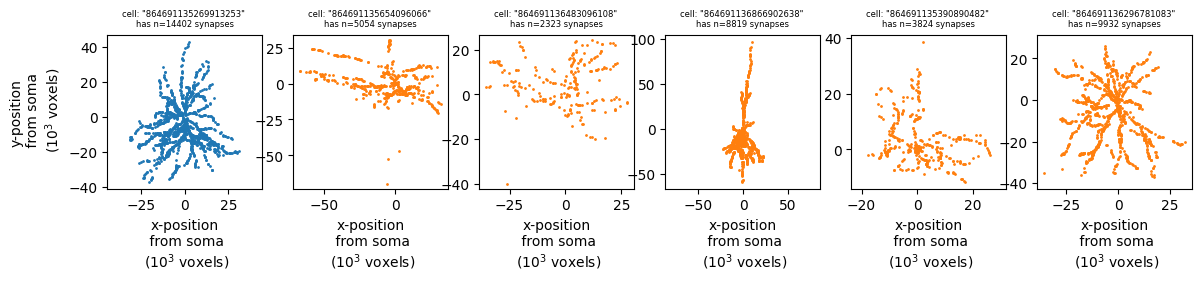

In [78]:
fig, AX = plt.subplots(1, 6, figsize=(14,2))
plot_synapses(cells['Basket']['segID'][0], ax=AX[0], color=plt.cm.tab10(0))
for i in range(5):
    plot_synapses(cells['Martinotti']['segID'][i], ax=AX[i+1], color=plt.cm.tab10(1))
AX[0].set_ylabel('y-position\n from soma\n (10$^3$ voxels)')